<a href="https://colab.research.google.com/github/AdityaGaur19/Airline-Crew-Scheduling-Optimization/blob/main/irline_Crew_Scheduling_%E2%80%93_NP_Hard_Problem_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💻 Airline Crew Scheduling – NP-Hard Problem Optimization
**Course:** Design and Analysis of Algorithms Lab (ENCA351)  
**Session:** 2025-26 | **Program:** BCA (AI & Data Science)  
**Student:** Aditya Gaur  
**Faculty:** Dr. Aarti Sangwan  
**Platform:** Google Colab  

In [10]:
# Cell 0
!pip install -q memory_profiler pandas matplotlib

import time
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import os
from typing import List, Tuple, Dict, Any, Optional
from copy import deepcopy

os.makedirs("images", exist_ok=True)
os.makedirs("tables", exist_ok=True)

In [11]:
# Cell 0.1
def mem_and_time(func, *args, **kwargs):
    base = memory_usage(proc=-1, interval=0.01, timeout=0.1)
    t0 = time.perf_counter()
    mem = memory_usage((func, args, kwargs), interval=0.01)
    t1 = time.perf_counter()
    return {"time": t1 - t0, "mem_mb": max(mem) - (base[0] if base else 0)}

def save_plot(fig, fname, dpi=150):
    fig.savefig(fname, bbox_inches="tight", dpi=dpi)
    plt.show()
    print("Saved ->", fname)

def save_df(df, fname):
    df.to_csv(fname, index=False)
    display(df)
    print("Saved ->", fname)

In [12]:
# Cell 1
flights = [
    ('F1', 9.0, 11.0),
    ('F2', 10.0, 12.0),
    ('F3', 13.0, 15.0),
    ('F4', 11.5, 13.0),
    ('F5', 16.0, 18.0)
]
crew = ['C1', 'C2', 'C3']
cost_map = {
    ('C1','F1'):100,('C2','F1'):120,('C3','F1'):110,
    ('C1','F2'):90, ('C2','F2'):95, ('C3','F2'):100,
    ('C1','F3'):130,('C2','F3'):120,('C3','F3'):140,
    ('C1','F4'):80, ('C2','F4'):85, ('C3','F4'):90,
    ('C1','F5'):150,('C2','F5'):140,('C3','F5'):145
}
MIN_REST = 1.0

In [13]:
# Cell 1.1
def flights_overlap(a,b,min_rest=0.0):
    _, s1,e1 = a; _, s2,e2 = b
    if e1 <= s2: return (s2 - e1) < min_rest
    if e2 <= s1: return (s1 - e2) < min_rest
    return True

def can_add(schedule, flight, min_rest):
    return all(not flights_overlap(f,flight,min_rest) for f in schedule)

In [14]:
# Cell 2
from itertools import combinations

def feasible_subsets(flights, min_rest):
    id2 = {f[0]:f for f in flights}
    ids = [f[0] for f in flights]
    feas = {}
    for r in range(1, len(ids)+1):
        for comb in combinations(ids, r):
            ok = True
            for x,y in combinations(comb,2):
                if flights_overlap(id2[x], id2[y], min_rest):
                    ok = False; break
            feas[comb] = ok
    return feas

_feas = feasible_subsets(flights, MIN_REST)
{k:v for k,v in _feas.items() if v}

{('F1',): True,
 ('F2',): True,
 ('F3',): True,
 ('F4',): True,
 ('F5',): True,
 ('F1', 'F3'): True,
 ('F1', 'F5'): True,
 ('F2', 'F3'): True,
 ('F2', 'F5'): True,
 ('F3', 'F5'): True,
 ('F4', 'F5'): True,
 ('F1', 'F3', 'F5'): True,
 ('F2', 'F3', 'F5'): True}

In [15]:
# Cell 3
def backtrack_csp(flights, crew, min_rest, time_limit=None):
    start = time.perf_counter()
    fs = sorted(flights, key=lambda x:x[1])
    n = len(fs)
    schedules = {c:[] for c in crew}
    solution = None
    calls = 0
    timeout = False

    def bt(i):
        nonlocal solution, calls, timeout
        calls += 1
        if time_limit and time.perf_counter()-start > time_limit:
            timeout = True; return
        if i==n:
            solution = {c:[f[0] for f in schedules[c]] for c in crew}
            timeout = True; return
        f = fs[i]
        for c in crew:
            if can_add(schedules[c], f, min_rest):
                schedules[c].append(f)
                bt(i+1)
                if timeout: return
                schedules[c].pop()

    bt(0)
    return {"solution": solution, "calls": calls, "time": time.perf_counter()-start}

res_csp = backtrack_csp(flights, crew, MIN_REST, time_limit=10)
print(res_csp)

{'solution': {'C1': ['F1', 'F3', 'F5'], 'C2': ['F2'], 'C3': ['F4']}, 'calls': 6, 'time': 3.504799997244845e-05}


In [16]:
# Cell 4
def backtrack_min_cost(flights, crew, min_rest, cost_map, time_limit=None):
    start = time.perf_counter()
    fs = sorted(flights, key=lambda x:x[1])
    n = len(fs)
    best = {"sol":None, "cost":float('inf')}
    schedules = {c:[] for c in crew}
    calls = 0
    timeout=False

    def lb(idx, cur_cost):
        est = cur_cost
        for j in range(idx,n):
            fid = fs[j][0]
            est += min(cost_map.get((c,fid), float('inf')) for c in crew)
            if est >= best["cost"]: break
        return est

    def bt(i, cur_cost):
        nonlocal calls, timeout, best
        calls += 1
        if time_limit and time.perf_counter()-start > time_limit:
            timeout=True; return
        if i==n:
            if cur_cost < best["cost"]:
                best["cost"] = cur_cost
                best["sol"] = {c:[f[0] for f in schedules[c]] for c in crew}
            return
        if lb(i,cur_cost) >= best["cost"]: return
        f = fs[i]; fid = f[0]
        for c in crew:
            cc = cost_map.get((c,fid), None)
            if cc is None: continue
            if can_add(schedules[c], f, min_rest):
                schedules[c].append(f)
                bt(i+1, cur_cost+cc)
                if timeout: return
                schedules[c].pop()

    bt(0,0.0)
    return {"best": best["sol"], "cost": best["cost"], "calls": calls, "time": time.perf_counter()-start}

res_cost = backtrack_min_cost(flights, crew, MIN_REST, cost_map, time_limit=10)
print(res_cost)

{'best': {'C1': ['F1'], 'C2': ['F2', 'F3', 'F5'], 'C3': ['F4']}, 'cost': 545.0, 'calls': 19, 'time': 0.00012083500007520342}


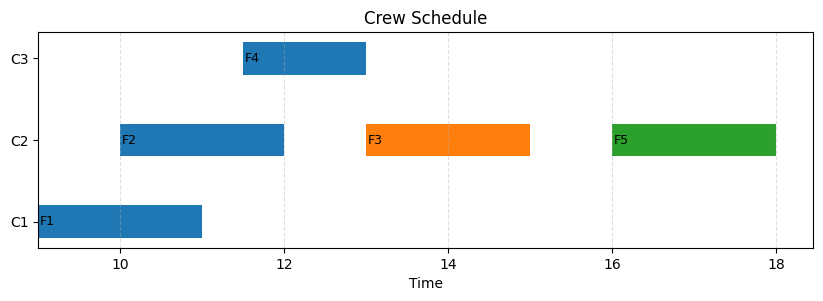

Saved -> images/gantt.png


In [17]:
# Cell 5
def plot_gantt(sol, flights, title, fname):
    if not sol: return
    id2 = {f[0]:f for f in flights}
    crews = list(sol.keys())
    fig, ax = plt.subplots(figsize=(10,1+0.6*len(crews)))
    colors = plt.cm.tab10.colors
    for i,c in enumerate(crews):
        for j,fid in enumerate(sol[c]):
            s,e = id2[fid][1], id2[fid][2]
            ax.barh(i, e-s, left=s, height=0.4, color=colors[j%10])
            ax.text(s+0.02, i, fid, va='center', fontsize=9)
    ax.set_yticks(range(len(crews))); ax.set_yticklabels(crews)
    ax.set_xlabel("Time"); ax.set_title(title); ax.grid(axis='x', ls='--', alpha=0.4)
    save_plot(fig, fname)

final_sol = res_cost.get("best") or res_csp.get("solution")
plot_gantt(final_sol, flights, "Crew Schedule", "images/gantt.png")

4 3.815900004155992e-05 5
5 2.7362000082575832e-05 6
6 2.688699998998345e-05 7
7 2.7476000013848534e-05 8


,n,time,calls
0,4,0.000038,5
1,5,0.000027,6
2,6,0.000027,7
3,7,0.000027,8


Saved -> tables/scaling.csv


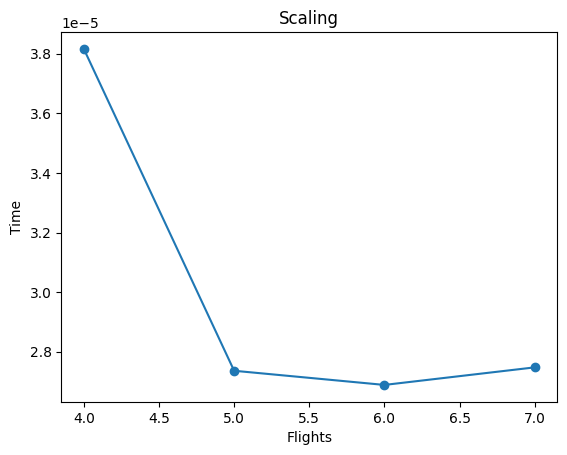

Saved -> images/scaling.png


In [18]:
# Cell 6
import random
def gen_flights(n):
    r = random.Random(42)
    out=[]
    for i in range(n):
        s = round(r.uniform(6, 20),2)
        d = max(0.5, round(r.gauss(2,0.4),2))
        e = round(min(s+d, 22),2)
        out.append((f"F{i+1}", s,e))
    return out

def scaling_test(ns=[4,5,6,7], crew_count=3, min_rest=1.0, tlim=10):
    rec=[]
    for n in ns:
        fls=gen_flights(n)
        cr=[f"C{i+1}" for i in range(crew_count)]
        r=backtrack_csp(fls,cr,min_rest,tlim)
        rec.append({"n":n,"time":r["time"],"calls":r["calls"]})
        print(n, r["time"], r["calls"])
    df=pd.DataFrame(rec); save_df(df,"tables/scaling.csv")
    fig,ax=plt.subplots()
    ax.plot(df["n"],df["time"],marker='o'); ax.set_title("Scaling"); ax.set_xlabel("Flights"); ax.set_ylabel("Time")
    save_plot(fig,"images/scaling.png")

df_scale = scaling_test()

In [19]:
# Cell 7
def export_solution(sol, flights, fname):
    if not sol: return
    id2={f[0]:f for f in flights}
    rows=[]
    for c,fls in sol.items():
        for fid in fls:
            s,e=id2[fid][1], id2[fid][2]
            rows.append({"crew":c,"flight":fid,"start":s,"end":e})
    df=pd.DataFrame(rows); save_df(df,fname)

export_solution(final_sol, flights, "tables/assignment.csv")

,crew,flight,start,end
0,C1,F1,9.0,11.0
1,C2,F2,10.0,12.0
2,C2,F3,13.0,15.0
3,C2,F5,16.0,18.0
4,C3,F4,11.5,13.0


Saved -> tables/assignment.csv


In [20]:
# Cell 8
print("Images:")
for f in sorted(os.listdir("images")): print(" -", f)
print("\nTables:")
for f in sorted(os.listdir("tables")): print(" -", f)

Images:
 - gantt.png
 - scaling.png

Tables:
 - assignment.csv
 - scaling.csv
